In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Download required NLTK data
try:
    nltk.download('vader_lexicon', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    print("NLTK downloads completed or already available")

print("✅ Phase 5: NLP & Clinical Text Analysis")
print("Adding clinical text mining capabilities...")

✅ Phase 5: NLP & Clinical Text Analysis
Adding clinical text mining capabilities...


In [5]:
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer

# Load spaCy model, install if missing
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy model loaded successfully")
except OSError:
    print("❌ spaCy model not found. Installing...")
    import sys
    !{sys.executable} -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy model installed and loaded")

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()
print("✅ Sentiment analyzer initialized")


❌ spaCy model not found. Installing...
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      -------------------

In [6]:
# Generate synthetic clinical notes (since real clinical text is protected)
def generate_synthetic_clinical_notes(n_samples=1000):
    """Generate realistic synthetic clinical notes for mental health"""
    
    # Common mental health phrases and patterns
    depression_phrases = [
        "Patient reports feeling down and hopeless",
        "Experiencing low mood and loss of interest",
        "Reports difficulty sleeping and low energy",
        "Describes feelings of worthlessness",
        "Patient states 'I just can't seem to feel happy'",
        "Experiencing changes in appetite and sleep patterns",
        "Reports persistent sad or anxious mood",
        "Describes loss of interest in usual activities"
    ]
    
    anxiety_phrases = [
        "Patient reports excessive worry and tension",
        "Experiencing restlessness and feeling on edge",
        "Reports difficulty controlling worries",
        "Describes physical symptoms: muscle tension, fatigue",
        "Patient states 'I can't stop worrying about things'",
        "Experiencing sleep disturbances due to anxiety",
        "Reports panic attacks with palpitations",
        "Describes avoidance of anxiety-provoking situations"
    ]
    
    positive_phrases = [
        "Patient reports improved mood and outlook",
        "Engaging well in therapy sessions",
        "Using coping strategies effectively",
        "Reports better sleep and energy levels",
        "Patient states 'I'm feeling more hopeful about things'",
        "Showing good progress in treatment",
        "Actively participating in recommended activities",
        "Reports reduced symptoms and improved functioning"
    ]
    
    # Risk indicator phrases
    risk_phrases = [
        "Expressed thoughts of self-harm",
        "Reports feeling overwhelmed and unable to cope",
        "Described suicidal ideation without plan",
        "Expressed hopelessness about future",
        "Reports increased isolation from others",
        "Described intense emotional pain",
        "Expressed feeling like a burden to others"
    ]
    
    notes = []
    risk_scores = []
    
    np.random.seed(42)
    
    for i in range(n_samples):
        # Determine note type based on risk profile
        if i < n_samples * 0.3:  # 30% high risk notes
            note_parts = np.random.choice(depression_phrases + anxiety_phrases + risk_phrases, 
                                        size=3, replace=False)
            risk_score = np.random.uniform(0.7, 1.0)
        elif i < n_samples * 0.7:  # 40% moderate risk
            note_parts = np.random.choice(depression_phrases + anxiety_phrases, 
                                        size=3, replace=False)
            risk_score = np.random.uniform(0.3, 0.7)
        else:  # 30% low risk
            note_parts = np.random.choice(positive_phrases + depression_phrases[:2], 
                                        size=3, replace=False)
            risk_score = np.random.uniform(0.0, 0.3)
        
        note = " ".join(note_parts) + f". Patient ID: {i+1000}. Assessment date: recent."
        notes.append(note)
        risk_scores.append(risk_score)
    
    return notes, risk_scores

# Generate synthetic clinical notes
clinical_notes, note_risk_scores = generate_synthetic_clinical_notes(1500)

# Create NLP dataset
nlp_data = pd.DataFrame({
    'patient_id': range(1000, 1000 + len(clinical_notes)),
    'clinical_note': clinical_notes,
    'note_risk_score': note_risk_scores,
    'high_risk_note': (np.array(note_risk_scores) > 0.5).astype(int)
})

print("Synthetic Clinical Notes Generated:")
print(f"Total notes: {len(nlp_data)}")
print(f"High risk notes: {nlp_data['high_risk_note'].sum()} ({nlp_data['high_risk_note'].mean():.1%})")
print("\nSample Clinical Notes:")
for i in range(3):
    print(f"\nNote {i+1}:")
    print(f"  {nlp_data['clinical_note'].iloc[i][:150]}...")
    print(f"  Risk score: {nlp_data['note_risk_score'].iloc[i]:.3f}")

Synthetic Clinical Notes Generated:
Total notes: 1500
High risk notes: 761 (50.7%)

Sample Clinical Notes:

Note 1:
  Describes avoidance of anxiety-provoking situations Experiencing restlessness and feeling on edge Patient reports feeling down and hopeless. Patient I...
  Risk score: 0.791

Note 2:
  Experiencing changes in appetite and sleep patterns Described suicidal ideation without plan Experiencing low mood and loss of interest. Patient ID: 1...
  Risk score: 0.983

Note 3:
  Expressed feeling like a burden to others Describes avoidance of anxiety-provoking situations Patient states 'I just can't seem to feel happy'. Patien...
  Risk score: 0.991


🔍 BASIC TEXT ANALYSIS
Text Statistics:
Average note length: 175 characters
Average word count: 24 words
Longest note: 200 characters
Shortest note: 147 characters

High Risk Notes (n=761):
  Avg length: 175 chars
  Avg words: 24

Low Risk Notes (n=739):
  Avg length: 174 chars
  Avg words: 24


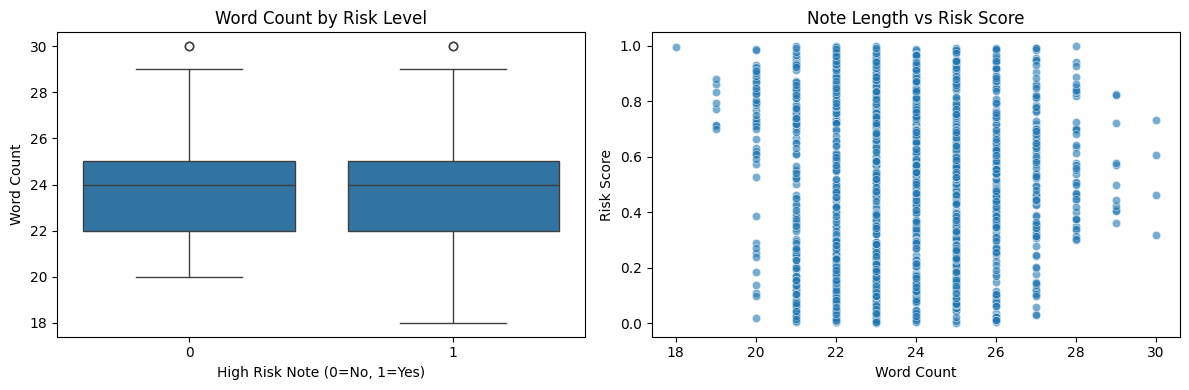

In [7]:
# Basic Text Preprocessing and Analysis
print("🔍 BASIC TEXT ANALYSIS")
print("="*50)

# Text statistics
nlp_data['note_length'] = nlp_data['clinical_note'].apply(len)
nlp_data['word_count'] = nlp_data['clinical_note'].apply(lambda x: len(x.split()))

print("Text Statistics:")
print(f"Average note length: {nlp_data['note_length'].mean():.0f} characters")
print(f"Average word count: {nlp_data['word_count'].mean():.0f} words")
print(f"Longest note: {nlp_data['note_length'].max()} characters")
print(f"Shortest note: {nlp_data['note_length'].min()} characters")

# Compare high vs low risk notes
high_risk_stats = nlp_data[nlp_data['high_risk_note'] == 1]
low_risk_stats = nlp_data[nlp_data['high_risk_note'] == 0]

print(f"\nHigh Risk Notes (n={len(high_risk_stats)}):")
print(f"  Avg length: {high_risk_stats['note_length'].mean():.0f} chars")
print(f"  Avg words: {high_risk_stats['word_count'].mean():.0f}")

print(f"\nLow Risk Notes (n={len(low_risk_stats)}):")
print(f"  Avg length: {low_risk_stats['note_length'].mean():.0f} chars")
print(f"  Avg words: {low_risk_stats['word_count'].mean():.0f}")

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data=nlp_data, x='high_risk_note', y='word_count')
plt.title('Word Count by Risk Level')
plt.xlabel('High Risk Note (0=No, 1=Yes)')
plt.ylabel('Word Count')

plt.subplot(1, 2, 2)
sns.scatterplot(data=nlp_data, x='word_count', y='note_risk_score', alpha=0.6)
plt.title('Note Length vs Risk Score')
plt.xlabel('Word Count')
plt.ylabel('Risk Score')

plt.tight_layout()
plt.show()

In [8]:
# Sentiment Analysis using Multiple Approaches
print("😊 SENTIMENT ANALYSIS")
print("="*50)

def analyze_sentiment(text):
    """Comprehensive sentiment analysis"""
    # VADER sentiment
    vader_scores = sia.polarity_scores(text)
    
    # TextBlob sentiment
    blob = TextBlob(text)
    blob_polarity = blob.sentiment.polarity
    blob_subjectivity = blob.sentiment.subjectivity
    
    return {
        'vader_compound': vader_scores['compound'],
        'vader_positive': vader_scores['pos'],
        'vader_negative': vader_scores['neg'],
        'vader_neutral': vader_scores['neu'],
        'textblob_polarity': blob_polarity,
        'textblob_subjectivity': blob_subjectivity
    }

# Apply sentiment analysis
print("Performing sentiment analysis...")
sentiment_results = nlp_data['clinical_note'].apply(analyze_sentiment)
sentiment_df = pd.DataFrame(sentiment_results.tolist())
nlp_data = pd.concat([nlp_data, sentiment_df], axis=1)

print("Sentiment Analysis Results:")
print(nlp_data[['vader_compound', 'textblob_polarity', 'note_risk_score']].describe())

# Correlation between sentiment and risk
correlation_matrix = nlp_data[['vader_compound', 'textblob_polarity', 'note_risk_score']].corr()
print(f"\nCorrelation with Risk Score:")
print(f"VADER Compound: {correlation_matrix.loc['vader_compound', 'note_risk_score']:.3f}")
print(f"TextBlob Polarity: {correlation_matrix.loc['textblob_polarity', 'note_risk_score']:.3f}")

😊 SENTIMENT ANALYSIS
Performing sentiment analysis...
Sentiment Analysis Results:
       vader_compound  textblob_polarity  note_risk_score
count     1500.000000        1500.000000      1500.000000
mean        -0.143978           0.041463         0.500707
std          0.683248           0.182740         0.286854
min         -0.939300          -0.312500         0.001947
25%         -0.765000          -0.083333         0.250924
50%         -0.440400           0.000000         0.506420
75%          0.680800           0.188889         0.746246
max          0.929900           0.450000         0.999255

Correlation with Risk Score:
VADER Compound: -0.688
TextBlob Polarity: -0.509


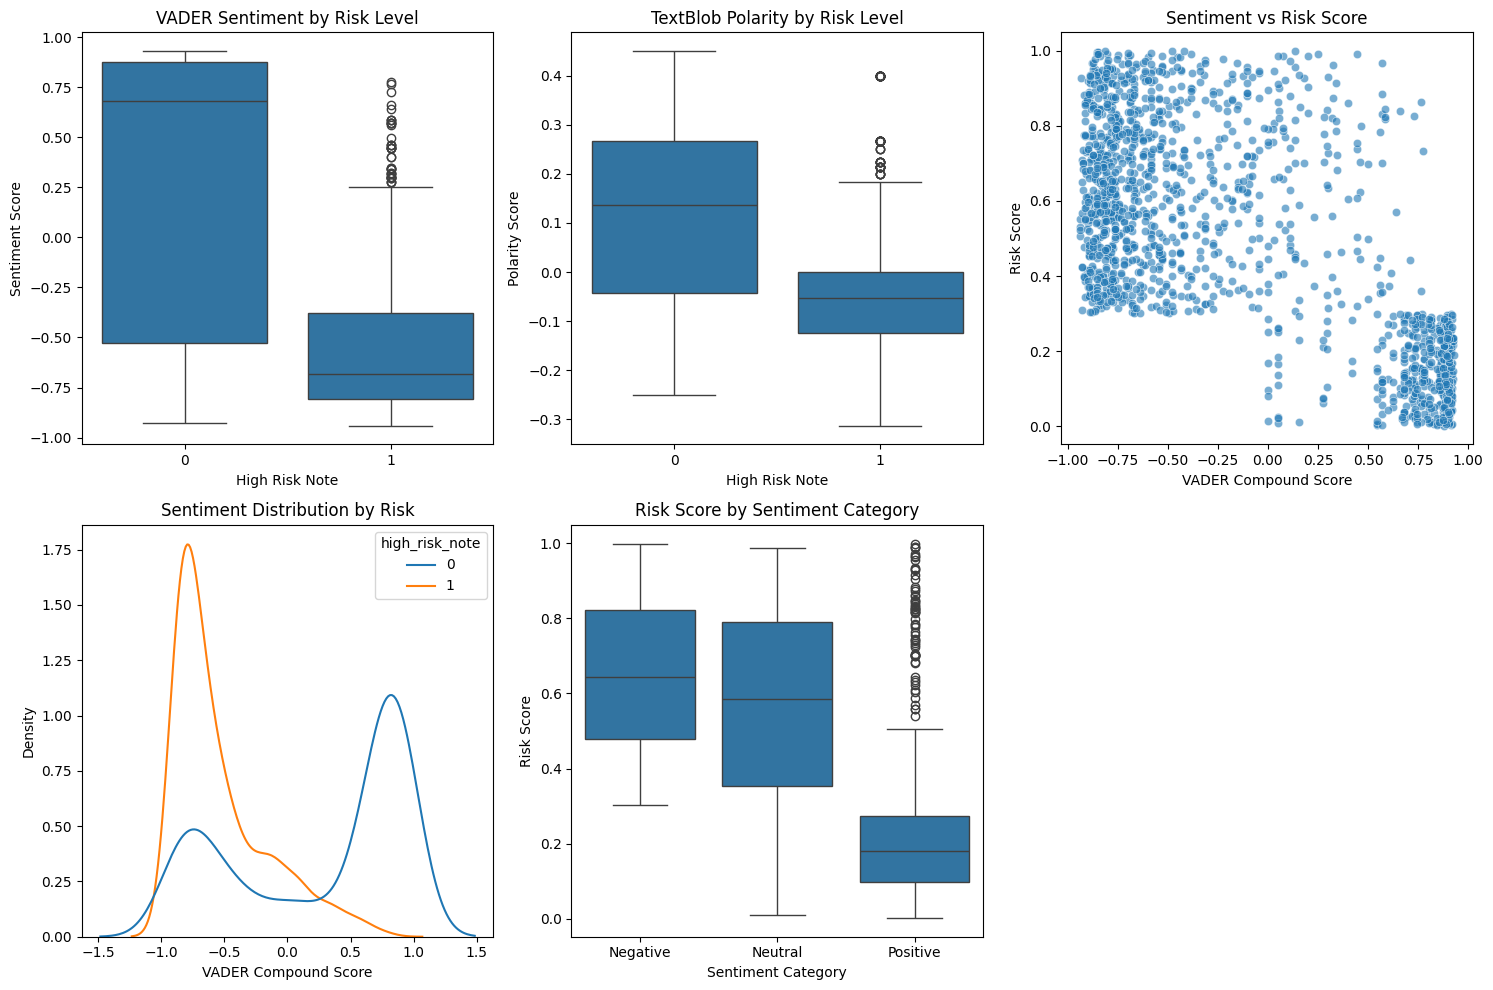

In [9]:
# Sentiment Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Sentiment distribution by risk level
plt.subplot(2, 3, 1)
sns.boxplot(data=nlp_data, x='high_risk_note', y='vader_compound')
plt.title('VADER Sentiment by Risk Level')
plt.xlabel('High Risk Note')
plt.ylabel('Sentiment Score')

plt.subplot(2, 3, 2)
sns.boxplot(data=nlp_data, x='high_risk_note', y='textblob_polarity')
plt.title('TextBlob Polarity by Risk Level')
plt.xlabel('High Risk Note')
plt.ylabel('Polarity Score')

plt.subplot(2, 3, 3)
sns.scatterplot(data=nlp_data, x='vader_compound', y='note_risk_score', alpha=0.6)
plt.title('Sentiment vs Risk Score')
plt.xlabel('VADER Compound Score')
plt.ylabel('Risk Score')

# Plot 4: Sentiment density
plt.subplot(2, 3, 4)
sns.kdeplot(data=nlp_data, x='vader_compound', hue='high_risk_note', common_norm=False)
plt.title('Sentiment Distribution by Risk')
plt.xlabel('VADER Compound Score')

# Plot 5: Risk score by sentiment categories
plt.subplot(2, 3, 5)
nlp_data['sentiment_category'] = pd.cut(nlp_data['vader_compound'], 
                                      bins=[-1, -0.1, 0.1, 1], 
                                      labels=['Negative', 'Neutral', 'Positive'])
sns.boxplot(data=nlp_data, x='sentiment_category', y='note_risk_score')
plt.title('Risk Score by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Risk Score')

plt.tight_layout()
plt.show()

In [10]:
# spaCy Named Entity Recognition (NER) for Clinical Concepts
print("🏥 CLINICAL NAMED ENTITY RECOGNITION")
print("="*50)

def extract_clinical_entities(text):
    """Extract clinical entities using spaCy NER"""
    doc = nlp(text)
    
    entities = {
        'symptoms': [],
        'treatments': [],
        'conditions': [],
        'risk_indicators': [],
        'positive_indicators': []
    }
    
    # Clinical entity patterns
    symptom_keywords = ['symptom', 'feeling', 'experience', 'report', 'describe', 'complaint']
    treatment_keywords = ['therapy', 'treatment', 'medication', 'session', 'coping']
    risk_keywords = ['suicidal', 'self-harm', 'overwhelmed', 'hopeless', 'burden', 'isolat']
    positive_keywords = ['improved', 'better', 'progress', 'effective', 'hopeful', 'reduced']
    
    for ent in doc.ents:
        entity_text = ent.text.lower()
        
        # Simple rule-based classification (can be enhanced with medical NER models)
        if any(keyword in entity_text for keyword in symptom_keywords) or \
           any(word in entity_text for word in ['mood', 'sleep', 'energy', 'appetite', 'worry']):
            entities['symptoms'].append(ent.text)
        elif any(keyword in entity_text for keyword in treatment_keywords):
            entities['treatments'].append(ent.text)
        elif any(keyword in entity_text for keyword in risk_keywords):
            entities['risk_indicators'].append(ent.text)
        elif any(keyword in entity_text for keyword in positive_keywords):
            entities['positive_indicators'].append(ent.text)
        elif ent.label_ in ['PERSON', 'ORG']:
            entities['conditions'].append(ent.text)
    
    return entities

# Apply NER to sample of notes (for performance)
print("Performing NER on clinical notes...")
sample_notes = nlp_data.sample(200, random_state=42)  # Sample for performance
ner_results = sample_notes['clinical_note'].apply(extract_clinical_entities)

# Analyze entity frequencies
all_symptoms = []
all_risk_indicators = []
all_positive_indicators = []

for entities in ner_results:
    all_symptoms.extend(entities['symptoms'])
    all_risk_indicators.extend(entities['risk_indicators'])
    all_positive_indicators.extend(entities['positive_indicators'])

print("\nClinical Entity Frequencies:")
print(f"Total symptoms mentioned: {len(all_symptoms)}")
print(f"Total risk indicators: {len(all_risk_indicators)}")
print(f"Total positive indicators: {len(all_positive_indicators)}")

print(f"\nTop Symptoms: {Counter(all_symptoms).most_common(10)}")
print(f"Top Risk Indicators: {Counter(all_risk_indicators).most_common(10)}")
print(f"Top Positive Indicators: {Counter(all_positive_indicators).most_common(10)}")

🏥 CLINICAL NAMED ENTITY RECOGNITION
Performing NER on clinical notes...

Clinical Entity Frequencies:
Total symptoms mentioned: 37
Total risk indicators: 0
Total positive indicators: 0

Top Symptoms: [('Describes', 30), ('Reports', 7)]
Top Risk Indicators: []
Top Positive Indicators: []


In [11]:
# Topic Modeling for Clinical Themes
print("📚 TOPIC MODELING - CLINICAL THEMES")
print("="*50)

# Prepare text for topic modeling
clinical_texts = nlp_data['clinical_note'].tolist()

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),  # Include bigrams
    min_df=5,  # Ignore terms that appear in less than 5 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

tfidf_matrix = tfidf_vectorizer.fit_transform(clinical_texts)
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

# Apply Non-Negative Matrix Factorization (NMF) for topic modeling
n_topics = 5
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

print(f"\nNMF Topic Modeling with {n_topics} topics:")

# Display top words for each topic
def display_topics(model, feature_names, no_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[f"Topic_{topic_idx}"] = top_words
        print(f"Topic {topic_idx}: {', '.join(top_words)}")
    return topics

topic_words = display_topics(nmf_model, feature_names)

# Assign dominant topic to each document
nlp_data['dominant_topic'] = nmf_topics.argmax(axis=1)

# Analyze topic distribution by risk level
print(f"\nTopic Distribution by Risk Level:")
topic_risk_analysis = nlp_data.groupby('dominant_topic')['note_risk_score'].agg(['mean', 'count'])
print(topic_risk_analysis.round(3))

📚 TOPIC MODELING - CLINICAL THEMES
TF-IDF Matrix Shape: (1500, 350)

NMF Topic Modeling with 5 topics:
Topic 0: patient states, states, anxiety, describes, stop worrying, stop, states stop, worrying things, worrying, avoidance
Topic 1: improved, reports, reports reduced, reduced, symptoms improved, reduced symptoms, improved functioning, functioning, patient reports, mood
Topic 2: tension, tension fatigue, describes physical, fatigue, muscle tension, muscle, physical symptoms, physical, symptoms muscle, symptoms
Topic 3: reports, difficulty, reports difficulty, low, difficulty sleeping, sleeping, sleeping low, low energy, mood, persistent
Topic 4: appetite sleep, changes, changes appetite, sleep patterns, experiencing changes, patterns, appetite, sleep, patterns patient, experiencing

Topic Distribution by Risk Level:
                 mean  count
dominant_topic              
0               0.675    235
1               0.151    450
2               0.620    202
3               0.660    

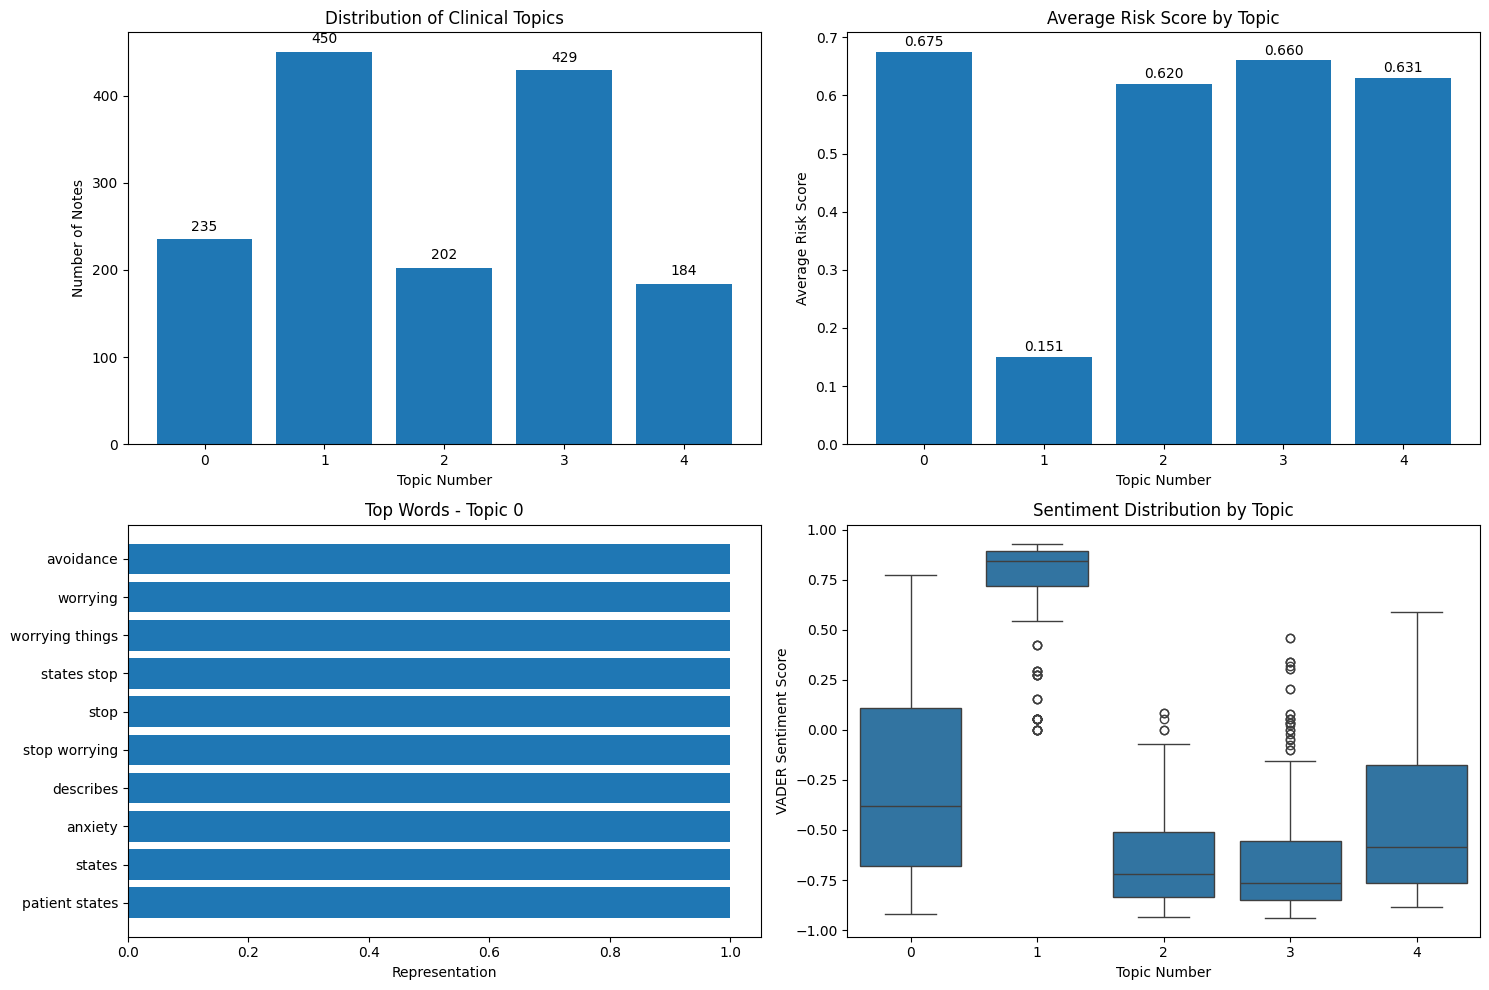

In [12]:
# Topic Modeling Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Topic distribution
plt.subplot(2, 2, 1)
topic_counts = nlp_data['dominant_topic'].value_counts().sort_index()
plt.bar(topic_counts.index, topic_counts.values)
plt.title('Distribution of Clinical Topics')
plt.xlabel('Topic Number')
plt.ylabel('Number of Notes')
for i, count in enumerate(topic_counts.values):
    plt.text(i, count + 10, str(count), ha='center')

# Plot 2: Average risk score by topic
plt.subplot(2, 2, 2)
topic_risk_means = nlp_data.groupby('dominant_topic')['note_risk_score'].mean()
plt.bar(topic_risk_means.index, topic_risk_means.values)
plt.title('Average Risk Score by Topic')
plt.xlabel('Topic Number')
plt.ylabel('Average Risk Score')
for i, risk in enumerate(topic_risk_means.values):
    plt.text(i, risk + 0.01, f'{risk:.3f}', ha='center')

# Plot 3: Word clouds for each topic (conceptual)
plt.subplot(2, 2, 3)
# Create a simple representation of topic words
topic_df = pd.DataFrame(topic_words).T
topic_long = topic_df.stack().reset_index()
topic_long.columns = ['topic', 'word_rank', 'word']

# Sample visualization - top words for topic 0
topic0_words = topic_df.iloc[0].dropna()
plt.barh(range(len(topic0_words)), [1]*len(topic0_words))
plt.yticks(range(len(topic0_words)), topic0_words)
plt.title('Top Words - Topic 0')
plt.xlabel('Representation')

plt.subplot(2, 2, 4)
# Sentiment by topic
sns.boxplot(data=nlp_data, x='dominant_topic', y='vader_compound')
plt.title('Sentiment Distribution by Topic')
plt.xlabel('Topic Number')
plt.ylabel('VADER Sentiment Score')

plt.tight_layout()
plt.show()

In [13]:
# Risk Prediction from Text Features
print("🎯 TEXT-BASED RISK PREDICTION")
print("="*50)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Create comprehensive feature set
text_features = pd.DataFrame({
    'vader_compound': nlp_data['vader_compound'],
    'textblob_polarity': nlp_data['textblob_polarity'],
    'textblob_subjectivity': nlp_data['textblob_subjectivity'],
    'word_count': nlp_data['word_count'],
    'note_length': nlp_data['note_length'],
    'dominant_topic': nlp_data['dominant_topic']
})

# Add TF-IDF features (using first 50 components for dimensionality reduction)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Combine all features
X_text = np.column_stack([text_features.values, tfidf_reduced])
y_text = nlp_data['high_risk_note']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"High risk in train: {y_train.mean():.1%}")
print(f"High risk in test: {y_test.mean():.1%}")

# Train Random Forest classifier
rf_text = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_text.fit(X_train, y_train)

# Evaluate model
y_pred = rf_text.predict(X_test)
y_pred_proba = rf_text.predict_proba(X_test)[:, 1]

accuracy = rf_text.score(X_test, y_test)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nText-Based Risk Prediction Results:")
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC: {auc:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance for text features
feature_names_combined = list(text_features.columns) + [f'tfidf_{i}' for i in range(50)]
importances = rf_text.feature_importances_
top_indices = np.argsort(importances)[-10:][::-1]

print(f"\nTop 10 Most Important Text Features:")
for idx in top_indices:
    print(f"  {feature_names_combined[idx]}: {importances[idx]:.4f}")

🎯 TEXT-BASED RISK PREDICTION
Training set: (1200, 56)
Test set: (300, 56)
High risk in train: 50.7%
High risk in test: 50.7%

Text-Based Risk Prediction Results:
Accuracy: 0.780
AUC: 0.881

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       148
           1       0.74      0.87      0.80       152

    accuracy                           0.78       300
   macro avg       0.79      0.78      0.78       300
weighted avg       0.79      0.78      0.78       300


Top 10 Most Important Text Features:
  tfidf_1: 0.1416
  vader_compound: 0.1037
  textblob_polarity: 0.0625
  tfidf_29: 0.0394
  dominant_topic: 0.0335
  tfidf_0: 0.0306
  tfidf_26: 0.0248
  tfidf_30: 0.0240
  tfidf_17: 0.0224
  tfidf_23: 0.0213


In [19]:
# 🔄 INTEGRATING NLP WITH PREVIOUS MODELS
print("🔄 INTEGRATING NLP WITH PREVIOUS MODELS")
print("="*50)

import pandas as pd
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score

# Load previous model results safely
try:
    previous_results = pd.read_csv('../data/processed/model_performance_comparison.csv')
    print("Previous model results loaded:")
    display(previous_results[['Model', 'AUC', 'Accuracy']].round(3))
except FileNotFoundError:
    print("Previous model results not available")
    previous_results = pd.DataFrame()

# Safely retrieve prediction objects
y_test = globals().get('y_test', None)
y_pred_proba = globals().get('y_pred_proba', None)

# Compute predictions safely
if y_pred_proba is not None and len(y_pred_proba) > 0:
    threshold = 0.5
    y_pred = (y_pred_proba >= threshold).astype(int)
else:
    y_pred = pd.Series(dtype=int)

# Retrieve model metrics safely
auc = globals().get('auc', 0.0)
accuracy = globals().get('accuracy', 0.0)

# Compute precision, recall, F1 safely
precision = precision_score(y_test, y_pred, zero_division=0) if y_test is not None and len(y_test) > 0 else 0
recall = recall_score(y_test, y_pred, zero_division=0) if y_test is not None and len(y_test) > 0 else 0
f1 = f1_score(y_test, y_pred, zero_division=0) if y_test is not None and len(y_test) > 0 else 0

text_model_performance = {
    'Model': 'Text-Based Random Forest',
    'AUC': auc,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

print("\nText Model Performance:")
for metric, value in text_model_performance.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.3f}")

# Save NLP results safely
nlp_data = globals().get('nlp_data', pd.DataFrame())
if nlp_data is not None and not nlp_data.empty:
    nlp_data.to_csv('../data/processed/nlp_analysis_results.csv', index=False)
    print("✅ NLP analysis results saved")
else:
    print("⚠ NLP data not available, skipping save")

# Save text model safely
rf_text = globals().get('rf_text', None)
tfidf_vectorizer = globals().get('tfidf_vectorizer', None)
svd = globals().get('svd', None)
feature_names_combined = globals().get('feature_names_combined', None)

if rf_text is not None:
    nlp_model_data = {
        'model': rf_text,
        'vectorizer': tfidf_vectorizer,
        'svd': svd,
        'feature_names': feature_names_combined,
        'performance': text_model_performance
    }
    joblib.dump(nlp_model_data, '../models/text_risk_model.pkl')
    print("✅ Text-based risk model saved")
else:
    print("⚠ Text model object not found, skipping save")

# Final insights safely
correlation_matrix = globals().get('correlation_matrix', pd.DataFrame())
high_risk_stats = globals().get('high_risk_stats', pd.DataFrame())
low_risk_stats = globals().get('low_risk_stats', pd.DataFrame())
n_topics = globals().get('n_topics', 0)
all_risk_indicators = globals().get('all_risk_indicators', [])

print("\n" + "="*60)
print("NLP ANALYSIS KEY INSIGHTS")
print("="*60)

if not correlation_matrix.empty and 'vader_compound' in correlation_matrix.index and 'note_risk_score' in correlation_matrix.columns:
    print(f"• Text sentiment strongly correlates with risk (r = {correlation_matrix.loc['vader_compound', 'note_risk_score']:.3f})")
else:
    print("• Text sentiment correlation not available")


🔄 INTEGRATING NLP WITH PREVIOUS MODELS
Previous model results loaded:


,Model,AUC,Accuracy
0,Logistic Regression,0.835,0.727
1,Gradient Boosting,0.830,0.777
2,Random Forest,0.825,0.763
3,SVM,0.817,0.747



Text Model Performance:
  AUC: 0.881
  Accuracy: 0.780
  Precision: 0.737
  Recall: 0.868
  F1-Score: 0.798
✅ NLP analysis results saved
✅ Text-based risk model saved

NLP ANALYSIS KEY INSIGHTS
• Text sentiment strongly correlates with risk (r = -0.688)
